# Multi-task model

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import os 
import shutil

import copy

import tensorflow as tf
import tensorflow.keras as K

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

## Load encoded cell line data

In [2]:
with pd.HDFStore('normalized_embeddings.h5') as store:
    print(store.keys())

['/ccle_test_ccleae', '/ccle_test_combinedae', '/ccle_test_mmrfae', '/ccle_train_ccleae', '/ccle_train_combinedae', '/ccle_train_mmrfae', '/ccle_valid_ccleae', '/ccle_valid_combinedae', '/ccle_valid_mmrfae', '/mmrf_test_ccleae', '/mmrf_test_combinedae', '/mmrf_test_mmrfae', '/mmrf_train_ccleae', '/mmrf_train_combinedae', '/mmrf_train_mmrfae', '/mmrf_valid_ccleae', '/mmrf_valid_combinedae', '/mmrf_valid_mmrfae']


In [35]:
X_train = pd.read_hdf("normalized_embeddings.h5", key = 'ccle_train_mmrfae', index_col=1)
X_train = X_train.set_index(X_train.iloc[:, 0])
X_train = X_train.iloc[: , 1:]

X_val = pd.read_hdf("normalized_embeddings.h5", key = 'ccle_valid_mmrfae', index_col=1)
X_val = X_val.set_index(X_val.iloc[:, 0])
X_val = X_val.iloc[: , 1:]

X_test = pd.read_hdf("normalized_embeddings.h5", key = 'ccle_test_mmrfae', index_col=1)
X_test = X_test.set_index(X_test.iloc[:, 0])
X_test = X_test.iloc[: , 1:]

In [4]:
crispr_rnaseq_merged = pd.read_csv('rnaseq_crispr_merged.csv')
crispr_rnaseq_merged = crispr_rnaseq_merged.set_index(['DepMap_ID'])
response_cols = [col for col in crispr_rnaseq_merged.columns if '_y' in col]
crispr = crispr_rnaseq_merged[response_cols]

In [36]:
train_index = list(set(X_train.index).intersection(crispr.index))
val_index = list(set(X_val.index).intersection(crispr.index))
test_index = list(set(X_test.index).intersection(crispr.index))

In [39]:
X_train = X_train.loc[train_index]
Y_train = crispr.loc[train_index]

X_val = X_val.loc[val_index]
Y_val = crispr.loc[val_index]

X_test = X_test.loc[test_index]
Y_test = crispr.loc[test_index]



In [40]:
#binary outcome used for classifier; postive = 1, negative = 0
bY_train = (Y_train >0).astype(int)
bY_val = (Y_val >0).astype(int)
bY_test = (Y_test >0).astype(int)

In [7]:
X_train.shape

(559, 128)

In [8]:
Y_train[:,1].shape

(559,)

# multi-task NN

In [99]:
def generate_classifier(N_in):
    inputs = K.layers.Input(shape = (N_in,))
    x = K.layers.Dense(64, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01))(inputs)
    x = K.layers.Dense(32, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01))(x)   
    y1 = K.layers.Dense(2, activation='softmax', kernel_regularizer=K.regularizers.l2(l=0.01), name='y1')(x)
    y2 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y2')(x)
    y3 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y3')(x)
    y4 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y4')(x)
    y5 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y5')(x)
    y6 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y6')(x)
    y7 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y7')(x)
    y8 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y8')(x)
    y9 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y9')(x)
    y10 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y10')(x)
    y11 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y11')(x)
    y12 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y12')(x)
    y13 = K.layers.Dense(2, activation='softmax',kernel_regularizer=K.regularizers.l2(l=0.01), name='y13')(x)

    model = K.models.Model(inputs = inputs, outputs = [y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13])
    model.compile(optimizer='adam',
                  loss=generate_loss(13, 'categorical_crossentropy'), metrics=['accuracy'])
    
    return model

In [87]:
def generate_regressor(N_in):
    inputs = K.layers.Input(shape = (N_in,))
    x = K.layers.Dense(64, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01))(inputs)
    x = K.layers.Dense(32, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01))(x)
    y1 = K.layers.Dense(1, activation='relu', kernel_regularizer=K.regularizers.l2(l=0.01), name='y1')(x)
    y2 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y2')(x)
    y3 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y3')(x)
    y4 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y4')(x)
    y5 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y5')(x)
    y6 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y6')(x)
    y7 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y7')(x)
    y8 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y8')(x)
    y9 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y9')(x)
    y10 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y10')(x)
    y11 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y11')(x)
    y12 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y12')(x)
    y13 = K.layers.Dense(1, activation='relu',kernel_regularizer=K.regularizers.l2(l=0.01), name='y13')(x)

    model = K.models.Model(inputs = inputs, outputs = [y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,y11,y12,y13])
    model.compile(optimizer='adam',
                  loss=generate_loss(13, 'mse'))
    
    return model

In [10]:
def generate_loss(N_out, loss):
    L = dict()
    for i in range(1, N_out+1):
        k = 'y'+str(i)
        L[k] = loss
    return L

In [55]:
def plot_pred(y_train, y_train_pred, y_test, y_test_pred, i):

    fig, ax = plt.subplots(1,1)

    ax.scatter(y_train[:,i],y_train_pred[i,:,0], label='Train', color='#4287f5')
    ax.scatter(y_test[:,i],y_test_pred[i,:,0], label='Test', color='#f2797f')
    # ax.set_xlim(-4,2)
    # ax.set_ylim(-4,2)
    ax.set_xlabel('True Response')
    ax.set_ylabel('Predicted Response')
    ax.legend()
    ax.set_title('CRISPR Knockout Experiment '+str(i))

In [48]:
def plot_loss(perf_dict):
    fig = plt.figure(figsize=(15,10))
    ax1 = plt.subplot(2,2,1)
    ax2 = plt.subplot(2,2,2)
    loss = perf_dict['loss']
    val_loss = perf_dict['val_loss']
    ax1.plot(loss)
    ax2.plot(val_loss)
    ax1.set_xlabel('epochs')
    ax2.set_xlabel('epochs')

    ax1.set_ylabel('loss')
    ax2.set_ylabel('val_loss')
    plt.show()

## train model

In [88]:
classifier = generate_classifier(X_train.shape[1])
classifier.summary()

print("Input", classifier.input_shape, "Output", classifier.output_shape)

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 64)           8256        input_10[0][0]                   
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 32)           2080        dense_9[0][0]                    
__________________________________________________________________________________________________
y1 (Dense)                      (None, 2)            66          dense_10[0][0]                   
____________________________________________________________________________________________

In [91]:
bY_train_oneHot = K.utils.to_categorical(bY_train, 2)
bY_val_oneHot = K.utils.to_categorical(bY_val, 2)

In [100]:

classifier_history = classifier.fit(X_train,bY_train_oneHot,epochs=100, validation_data=(X_val, bY_val_oneHot),verbose=0)

InvalidArgumentError:  logits and labels must have the same first dimension, got logits shape [32,2] and labels shape [832]
	 [[node sparse_categorical_crossentropy_6/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits (defined at <ipython-input-92-5c6c869894a9>:1) ]] [Op:__inference_train_function_4932948]

Function call stack:
train_function


## regressor

In [45]:
regressor = generate_regressor(X_train.shape[1])
regressor.summary()

print("Input", regressor.input_shape, "Output", regressor.output_shape)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 32)           4128        input_6[0][0]                    
__________________________________________________________________________________________________
y1 (Dense)                      (None, 1)            33          dense_5[0][0]                    
__________________________________________________________________________________________________
y2 (Dense)                      (None, 1)            33          dense_5[0][0]                    
____________________________________________________________________________________________

In [95]:
regressor_history = regressor.fit(X_train,Y_train,epochs=10000,batch_size=128,  validation_data=(X_val, Y_val),verbose=0)

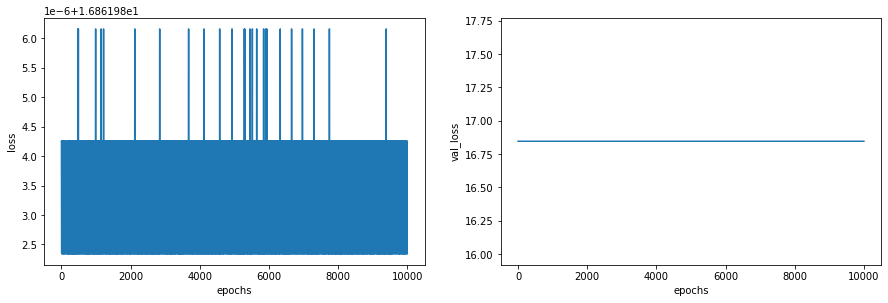

In [96]:
plot_loss(regressor_history.history)

In [97]:
y_train_regressorPred = np.array(regressor.predict(X_train))
y_test_regressorPred = np.array(regressor.predict(X_test))

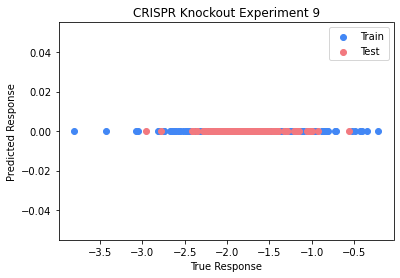

In [98]:
plot_pred(np.array(Y_train), y_train_regressorPred, np.array(Y_test), y_test_regressorPred, 9)

# Feature transfer patient data
Freeze network except the last layer, then train on patient data

In [ ]:
model.summary()

In [ ]:
model.trainable = False
model.layers[-1].trainable = True

layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])      

In [ ]:
history_pt = model.fit(X_pt_train, y_pt_train, epochs=100, validation_data=(X_pt_test, y_pt_test))

In [ ]:
plt.scatter(y_pt_test,model.predict(X_pt_test))

# Save model

In [ ]:
model = K.models.load_model(model_dir)

In [ ]:
model_dir = os.path.join('6.871models', 'simpleNN042721')
shutil.rmtree(model_dir)
model.save(model_dir)
